In [55]:
import pandas as pd
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
df = pd.read_excel('./datasets/dev_test_set_u_prelabelled_labelled.xls')
df = df[~df['human_label'].isnull()]

In [27]:
df.head()

,id,comp_name,sentence,model_most_likely,human_label
0,07e45bf1b3a39e5d,engie,ENGIE are recruiting for a Mobile Contract Sup...,0.0,0
1,07e45bf1b3a39e5d,engie,"This is a permanent, full time role working 40...",0.0,0
2,07e45bf1b3a39e5d,engie,"On offer is a salary of ¬£35,000 - ¬£37,500 de...",0.0,1
3,07e45bf1b3a39e5d,engie,Provide Technical Assistance to other Engineer...,0.0,0
4,07e45bf1b3a39e5d,engie,Maintain all PPM and Reactive Repairs Records ...,0.0,0


In [28]:
df.human_label.value_counts()

0                1663
8                  75
12                 35
9                  34
4                  21
17                 18
3, 8               13
7                  12
16                 10
8, 9                9
1                   8
10                  8
3                   7
9, 11               6
7, 9                6
7, 13               5
5, 10               5
8, 12               4
13                  4
11                  4
4, 8                4
1, 8                3
8, 11               3
8, 13               3
8, 16               2
16, 17              2
3, 8, 11            2
7, 9, 13            2
3, 11               2
9, 13               2
11, 12              2
9, 17               1
8, 9, 12            1
3, 4, 8, 13         1
10, 11, 13          1
3, 8, 13            1
8, 13, 16           1
8, 9, 12, 13        1
11, 17              1
8, 17               1
4, 8, 11            1
8, 13, 14, 15       1
7, 8, 9, 11         1
3, 8, 9             1
7, 8, 13, 15        1
12, 16    

In [29]:
nb_classes = 18
# RoBERTa model requires single column one-hot-encoded labels 
# this function returns this format from the usual numeric class label
def one_hot_encode(labels):
    """
    Gets an integer as argument representing the target class label. 
    As RoBERTa needs the targets in tuple one_hot_encoded format, 
    a tuple is returned which has a 1 at the position of the target class. 
    E.g. 2 -> (0,0,1,0,0,...)
    """
    t = [0 for i in range(nb_classes)]
    for label in labels:
        t[int(label)] = 1
    return list(t)

In [30]:
# one-hot-encode predictions in list format for confusion matrix preprocessing.
df['model_pred_one_hot'] = df['model_most_likely'].apply(lambda x: one_hot_encode(str(int(x)).split(", ")))
df['human_pred_one_hot'] = df['human_label'].apply(lambda x: one_hot_encode(str(x).split(", ")))

In [31]:
df.head()

,id,comp_name,sentence,model_most_likely,human_label,model_pred_one_hot,human_pred_one_hot
0,07e45bf1b3a39e5d,engie,ENGIE are recruiting for a Mobile Contract Sup...,0.0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,07e45bf1b3a39e5d,engie,"This is a permanent, full time role working 40...",0.0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,07e45bf1b3a39e5d,engie,"On offer is a salary of ¬£35,000 - ¬£37,500 de...",0.0,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,07e45bf1b3a39e5d,engie,Provide Technical Assistance to other Engineer...,0.0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,07e45bf1b3a39e5d,engie,Maintain all PPM and Reactive Repairs Records ...,0.0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [37]:
y_pred = np.array(list(df['model_pred_one_hot'].values))
y_true = np.array(list(df['human_pred_one_hot'].values))

In [47]:
labels = ['SDG {}'.format(c) for c in range(nb_classes)]
mlc = multilabel_confusion_matrix(y_true, y_pred)

In [49]:
def calculate_stats_text(cm):
    """
    Calculate statistics for binary label confusion matrix and return well formated text.
    """
    #Accuracy is sum of diagonal divided by total observations
    acc  = np.trace(cm) / float(np.sum(cm))

    p = cm[1,1] / sum(cm[:,1])
    r    = cm[1,1] / sum(cm[1,:])
    f1  = 2*p*r / (p + r)
    stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
        acc, p, r, f1)
    return stats_text



<ipython-input-49-c67238bef497>:9: RuntimeWarning: invalid value encountered in long_scalars
  r    = cm[1,1] / sum(cm[1,:])
<ipython-input-49-c67238bef497>:10: RuntimeWarning: invalid value encountered in double_scalars
  f1  = 2*p*r / (p + r)


<Figure size 720x360 with 0 Axes>

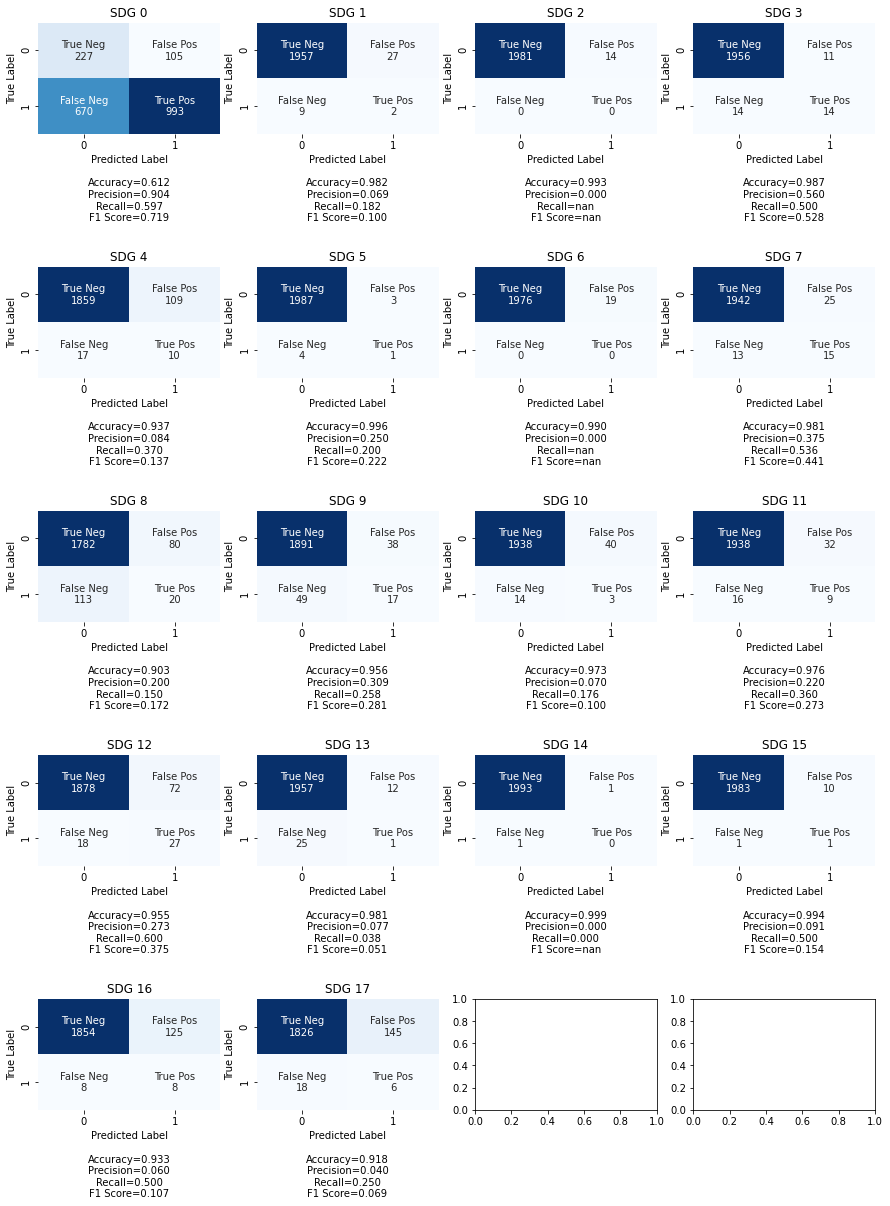

In [134]:
annot = ['True Neg','False Pos','False Neg','True Pos']

#label = labels[0]
#cm = mlc[0]
#stat = calculate_stats_text(cm)

#annot = ["{}\n{}".format(a, n) for a,n in zip(annot, cm.flatten())]
#annot = np.asarray(annot).reshape(cm.shape[0],cm.shape[1])
#plt.figure(figsize=(4,3))

I = 5
J = 4
counter = 0
plt.figure(figsize=(10,5))
fig, axs = plt.subplots(I, J, figsize=(15,20))
for i in range(I):
    for j in range(J):
        if counter < 18:
            cm = mlc[counter]
            label = labels[counter]
            stat = calculate_stats_text(cm)
            ann = ["{}\n{}".format(a, n) for a,n in zip(annot, cm.flatten())]
            a = np.asarray(ann).reshape(cm.shape[0],cm.shape[1])
            sns.heatmap(data=cm, cmap='Blues', fmt='4', annot=a, ax=axs[i, j], cbar=False)
            axs[i, j].set_title(label)
            axs[i, j].set_ylabel('True Label')
            axs[i, j].set_xlabel('Predicted Label' + stat)
            
            plt.subplots_adjust(hspace=1.2)
            
            counter += 1
            
plt.savefig('./plots/dev_test_CMs_run_1.png')

#for ax in axs.flat:
#    ax.set(xlabel='x-label', ylabel='y-label')

In [54]:
plt.figure(figsize=(8,6))


TypeError: 'module' object is not callable